In [129]:
import os
import re

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from pandas.plotting import scatter_matrix

%run model.py
%run plotPerformance.py
%run paramPipeline.py
%run betweenCompare.py

%matplotlib inline

np.random.seed(1234)

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

data = pd.read_csv(datadir + "complete.csv", index_col = 0)

# Feature Selection

In [3]:
#Drop reputation-based features
data2 = data.drop(["followers_count", "friends_count"], axis = 1)

In [8]:
#Drop highly correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

#Ignore mv features
mv_cols = list(data.filter(like='mv').columns)
mv_cols
data_mv = data[data.columns.difference(mv_cols)]

data3 = correlation(data_mv, 0.75)

In [5]:
#three models to test the datasets
dt_data = DecisionTreeClassifier(criterion="entropy")
lr_data = LogisticRegression()

data_choosers = {'data': data, 'data2': data2, 'data3': data3}

kfolds = KFold(10, True, random_state = 1234)


In [6]:
#Choose data set with highest mean auc
for dataset in data_choosers:
    aucs = list(cross_val_score(dt_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    aucs.extend(cross_val_score(lr_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    
    print("For {0}, mean auc is {1}:".format(dataset, np.round(np.mean(aucs), decimals = 3))) 

For data, mean auc is 0.714:
For data2, mean auc is 0.72:
For data3, mean auc is 0.71:


In [4]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data2.drop('label', 1), data2.label, test_size=0.2, random_state = 1234)

In [5]:
dt = Model("Decision Tree", DecisionTreeClassifier(criterion="entropy"), X_train, y_train, X_test, y_test)

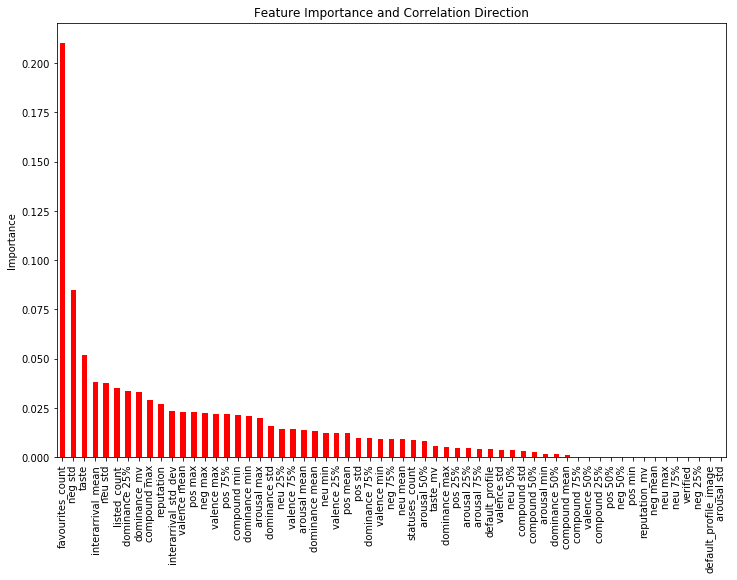

In [6]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.best_iteration.model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'].drop('label'))
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB7CBB4CC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001FB005B7470>]], dtype=object)

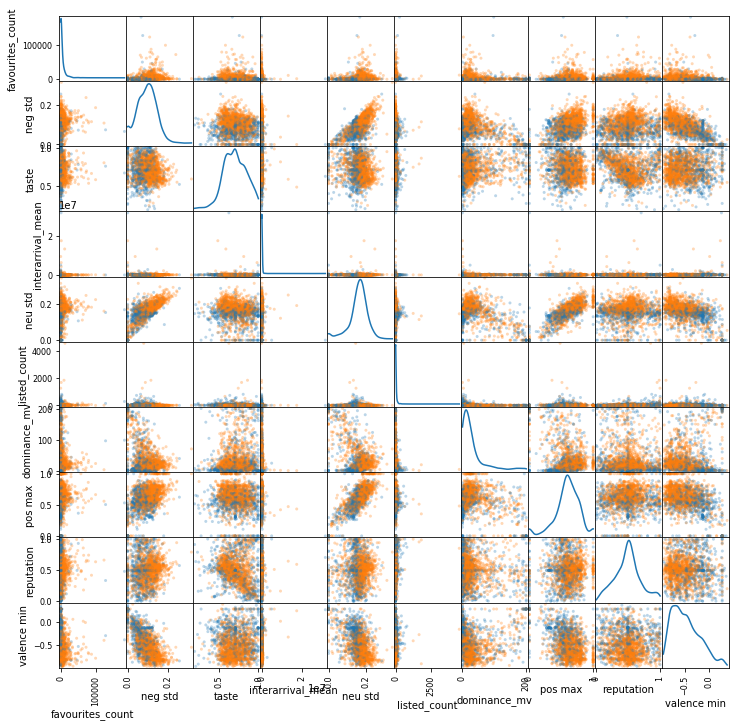

In [10]:
eda_data = X_train.copy()
eda_y = y_train.copy()

scatter_matrix(eda_data[features_summary.head(10).index], alpha=0.3, figsize=(12, 12), diagonal='kde',
              color=np.where(eda_y==1,'C0','C1'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB01D5BBA8>,
        ...,
        ...,
        ...,
       ..., 
        ...,
        ...,
        ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001FB41726438>]], dtype=object)

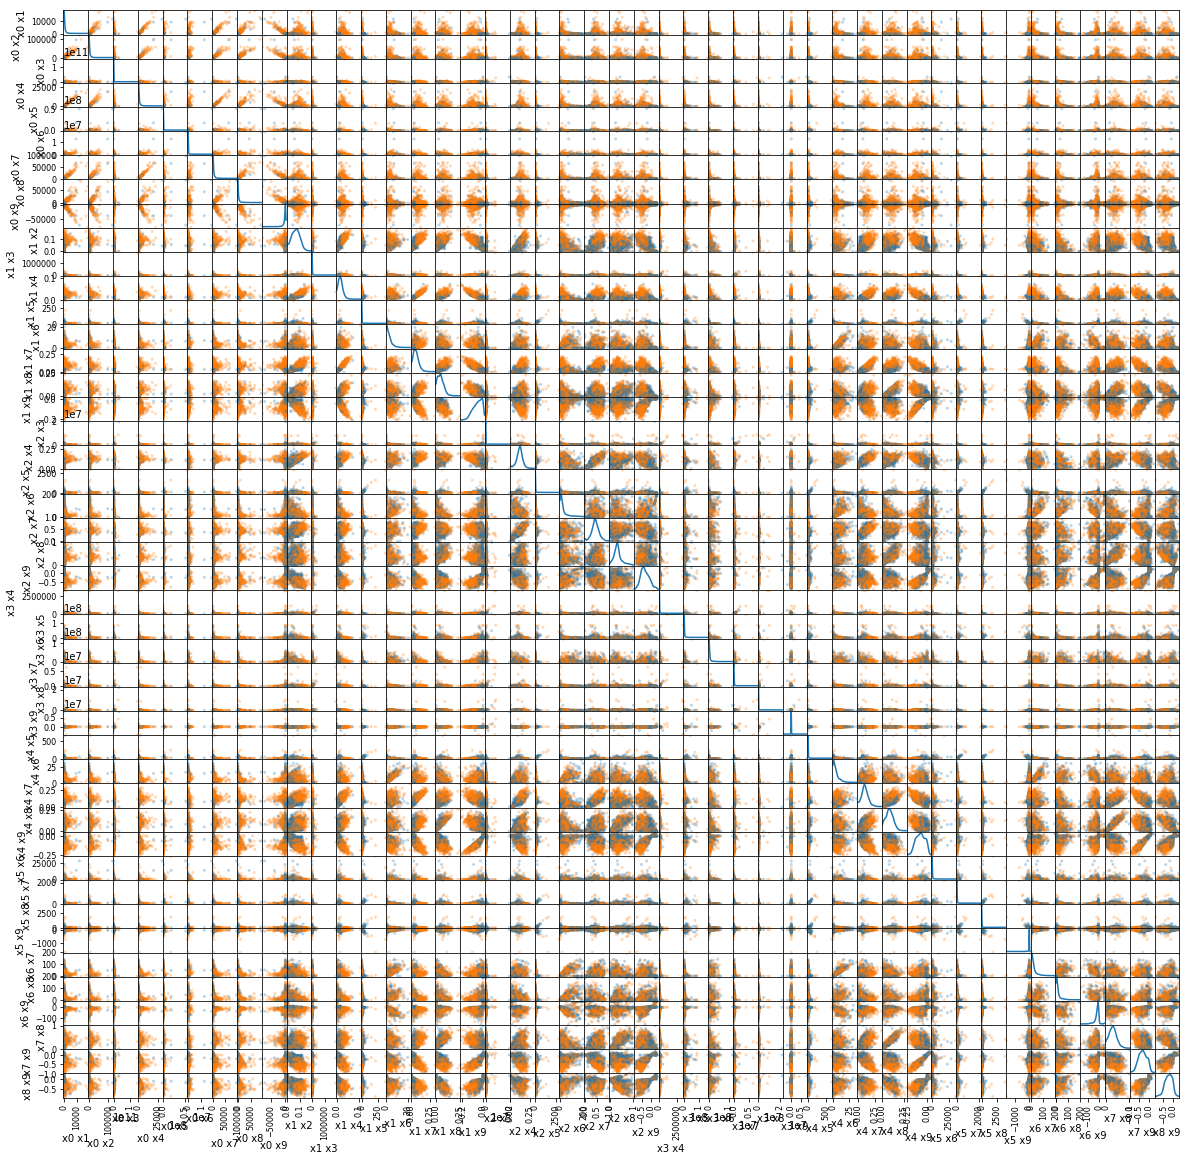

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
eda_poly = pd.DataFrame(poly.fit_transform(eda_data[features_summary.head(10).index]),
                           columns=poly.get_feature_names(),
                           index = eda_data.index)

scatter_matrix(eda_poly.iloc[:,11:], alpha=0.3, figsize=(20, 20), diagonal='kde',
              color=np.where(eda_y==1,'C0','C1'))

# Train Baseline Model

In [130]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

#Scale scalable features
scalable = X_train_filt[X_train_filt.columns.difference(mv_cols)].select_dtypes(exclude = ["bool"]).columns
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_filt[scalable].copy())

X_trained = X_train_filt.copy()
X_tested = X_test_filt.copy()

X_trained[scalable] = scaler.transform(X_trained[scalable])
X_tested[scalable] = scaler.transform(X_tested[scalable])

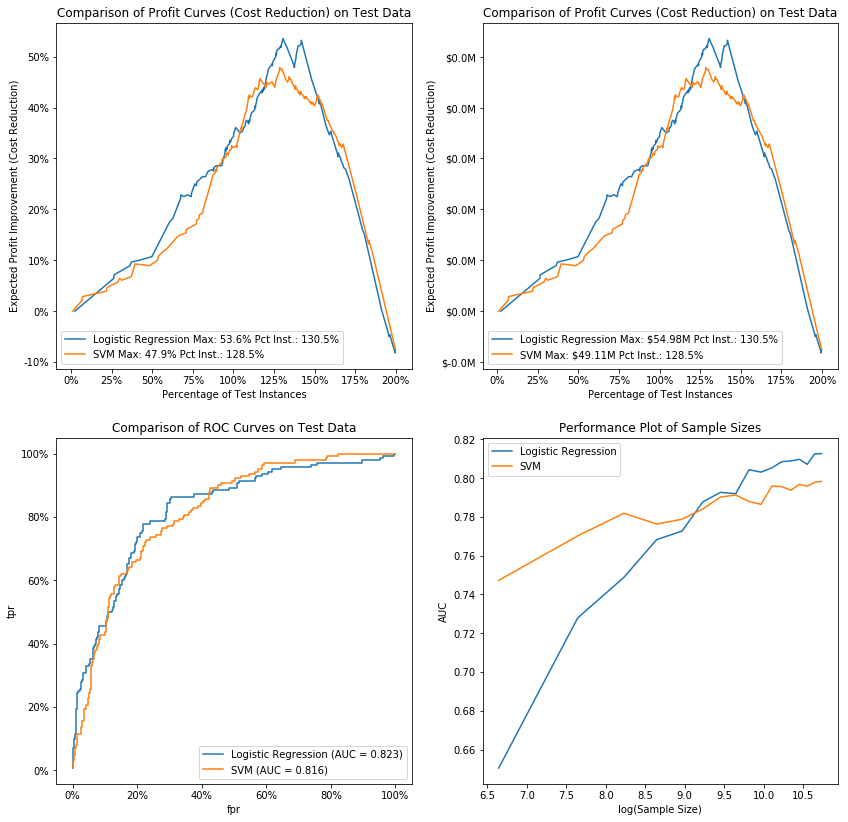

In [131]:
# Baseline Logistic Regression and SVM
lr = Model("Logistic Regression", LogisticRegression(C=1e30), X_trained, y_train, X_tested, y_test)
svm = Model("SVM", SVC(probability = True), X_trained, y_train, X_tested, y_test)
plotPerformance([lr,svm], list(range(100,X_trained.shape[0],100)), 20)

### Pipelines

# Logistic Regression

## Model Initialization

In [132]:
poly = PolynomialFeatures(2)

X_trained_poly = pd.DataFrame(poly.fit_transform(X_trained))
X_tested_poly = pd.DataFrame(poly.transform(X_tested))

In [133]:
lrc = Model("LR", LogisticRegression(), X_trained_poly, y_train, X_tested_poly, y_test)

## Iteration 1

Best Score: 0.791566

Best Params:  {'estimator__C': 0.01}


{'C': 0.001}

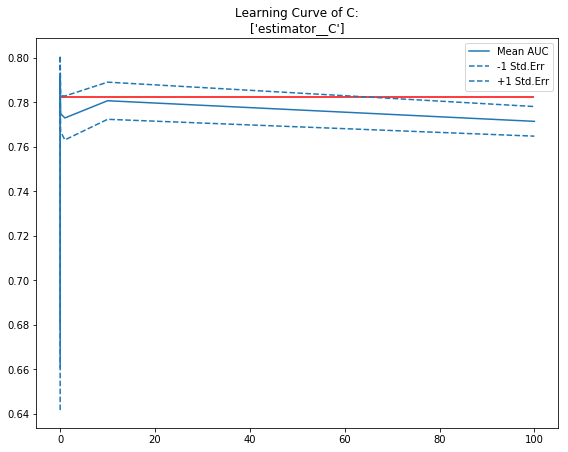

In [134]:
lrc.addIteration("C", LogisticRegression(**lrc.parameters), 
                {'estimator__C': [10**x for x in range(-8,3)]}, 
                 reg = True, plot = True)

lrc.parameters

# SVM

## Model Initialization

In [135]:
svm = Model("SVM", SVC(probability = True), X_trained, y_train, X_tested, y_test)

svm.parameters['probability'] = True

## Iteration 1

In [136]:
svm.addIteration("Kernel", SVC(**svm.parameters), 
                {'estimator__kernel': ['linear','rbf','sigmoid']},
                plot = False)

svm.parameters

Best Score: 0.81281

Best Params:  {'estimator__kernel': 'rbf'}


{'kernel': 'rbf', 'probability': True}

## Iteration 2

Best Score: 0.81281

Best Params:  {'estimator__C': 1}


{'C': 1, 'kernel': 'rbf', 'probability': True}

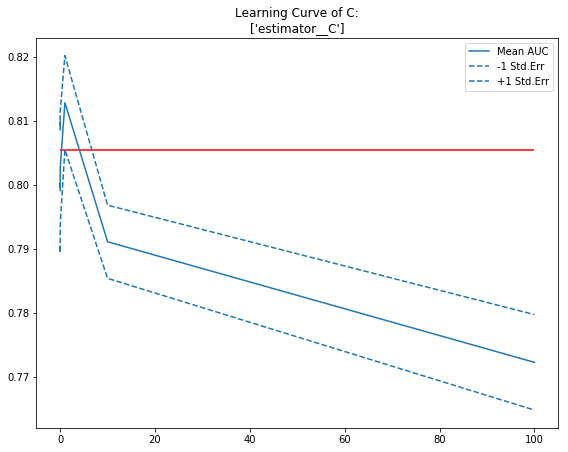

In [137]:
svm.addIteration("C", SVC(**svm.parameters), 
                {'estimator__C': [10**x for x in range(-8,3)]}, 
                 reg = True, plot = True)

svm.parameters

# GBM 

## Model Initialization

In [141]:
gbc = Model("GBC", GradientBoostingClassifier(), X_trained, y_train, X_tested, y_test)

 ## Iteration 1

Best Score: 0.858084

Best Params:  {'estimator__n_estimators': 70}


{'n_estimators': 50}

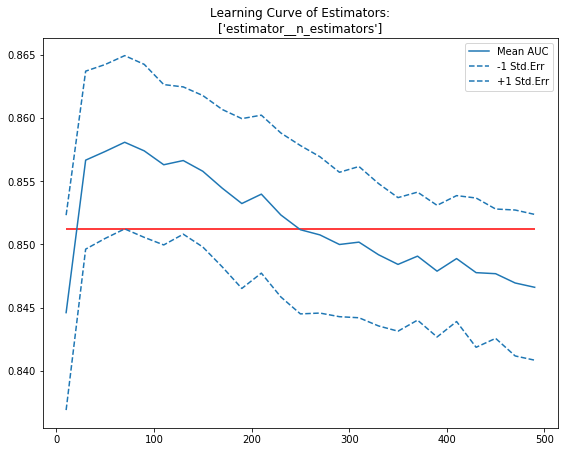

In [142]:
gbc.addIteration("Estimators", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,500,20))}, 
                 reg = True, plot = True)
gbc.parameters

## Iteration 2 

Best Score: 0.858069

Best Params:  {'estimator__max_depth': 3}


{'max_depth': 2, 'n_estimators': 50}

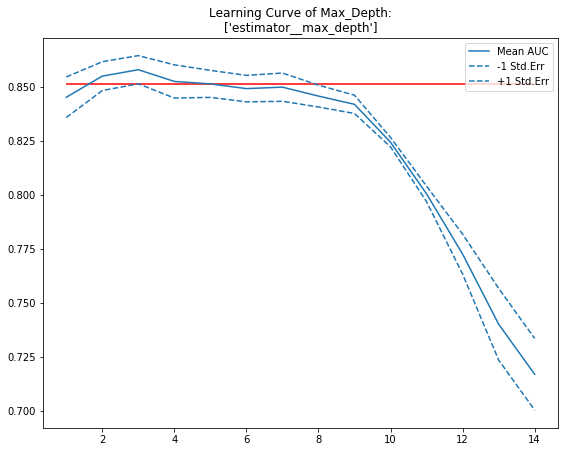

In [143]:
gbc.addIteration("Max_Depth", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_depth': list(range(1,15))}, 
                 reg = True, plot = True)

gbc.parameters['max_depth'] = 2
gbc.parameters

## Iteration 3

Best Score: 0.85855

Best Params:  {'estimator__min_samples_leaf': 105}


{'max_depth': 2, 'min_samples_leaf': 38, 'n_estimators': 50}

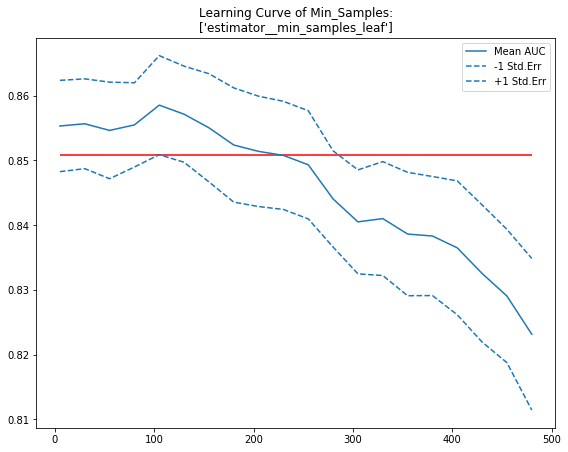

In [144]:
gbc.addIteration("Min_Samples", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__min_samples_leaf': list(range(5,500,25))},
                 reg = True, plot = True)

gbc.parameters

## Iteration 4

Best Score: 0.857552

Best Params:  {'estimator__max_features': 8}


{'max_depth': 2,
 'max_features': 0.1702127659574468,
 'min_samples_leaf': 38,
 'n_estimators': 50}

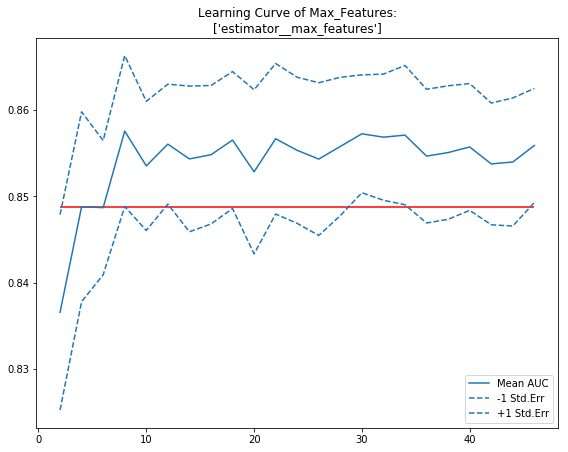

In [145]:
gbc.addIteration("Max_Features", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_features': list(range(2,X_trained.shape[1],2))}, 
                 reg = True, plot = True)

gbc.parameters['max_features'] = gbc.parameters['max_features']/X_trained.shape[1]
gbc.parameters

## Iteration 5

Best Score: 0.859733

Best Params:  {'estimator__subsample': 0.55000000000000004}


{'max_depth': 2,
 'max_features': 0.1702127659574468,
 'min_samples_leaf': 38,
 'n_estimators': 50,
 'subsample': 0.8}

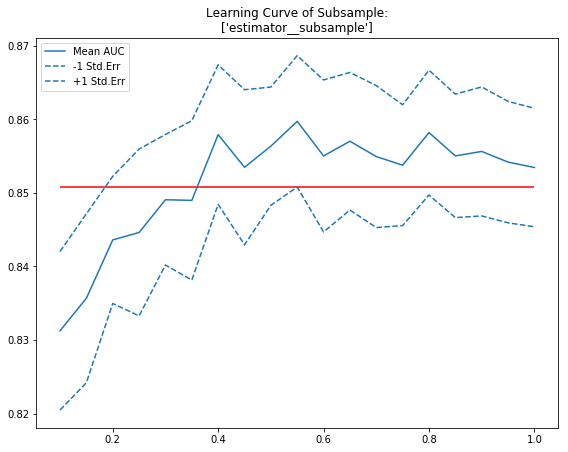

In [146]:
gbc.addIteration("Subsample", 
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100}, 
                des = False, reg = True, plot = True)

gbc.parameters

## Interation 6 

Best Score: 0.862986

Best Params:  {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 910}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.1702127659574468,
 'min_samples_leaf': 38,
 'n_estimators': 810,
 'subsample': 0.8}

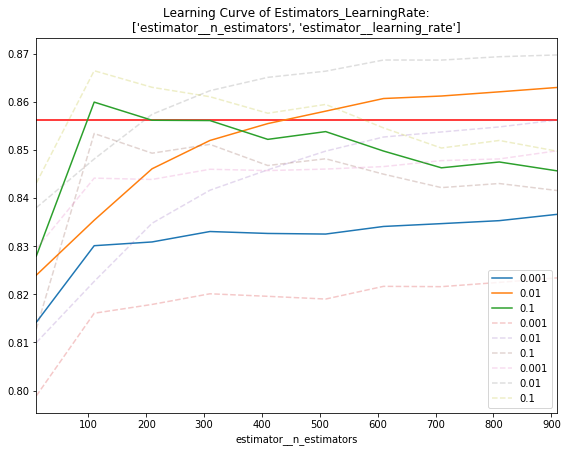

In [147]:
gbc.addIteration("Estimators_LearningRate",
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,1000,100)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]}, 
                 reg = True, plot = True)

gbc.parameters

## Iteration 7

Best Score: 0.863379

Best Params:  {'estimator__n_estimators': 1400}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.1702127659574468,
 'min_samples_leaf': 38,
 'n_estimators': 1050,
 'subsample': 0.8}

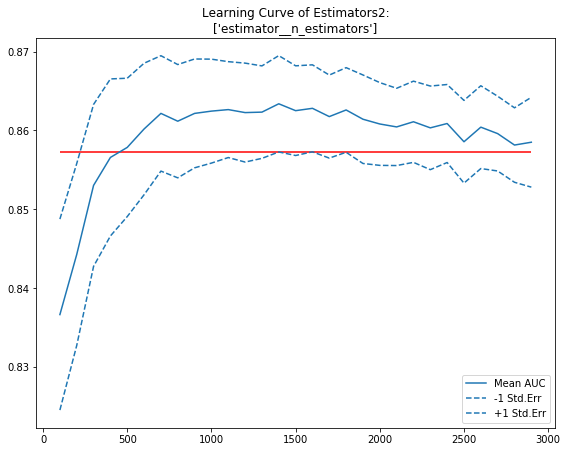

In [148]:
gbc.addIteration("Estimators2", 
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(100,3000,100))},
                reg = True, plot = True)

gbc.parameters

## Iteration 8

Best Score: 0.840892

Best Params:  {'feat_select__k': 6}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.1702127659574468,
 'min_samples_leaf': 38,
 'n_estimators': 1050,
 'subsample': 0.8}

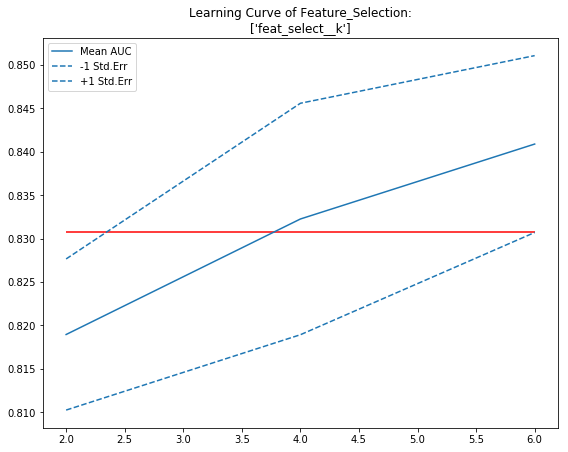

In [149]:
feature_pipeline = Pipeline([('feat_select', SelectKBest(mutual_info_classif, k = all)),
                             ('estimator', GradientBoostingClassifier(**gbc.parameters))])
                                    
gbc.addIteration("Feature_Selection", 
                GradientBoostingClassifier(**gbc.parameters),
                {'feat_select__k': list(range(2,int(gbc.parameters['max_features']*X_trained.shape[1]),2))},
                pipeline = feature_pipeline, 
                plot = True)

gbc.parameters

## GBC Compare 

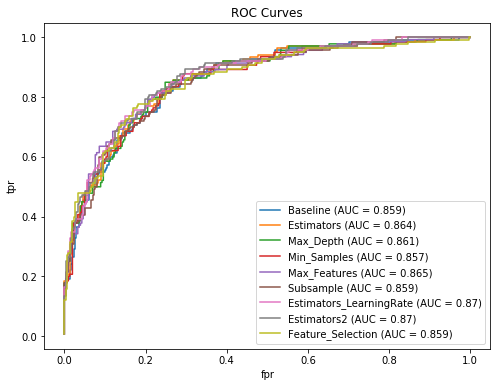

In [150]:
gbc.withinCompare()

# Random Forest

## Model Initialization

In [151]:
rdf = Model("RDF", RandomForestClassifier(), X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.860068

Best Params:  {'estimator__n_estimators': 161}


{}

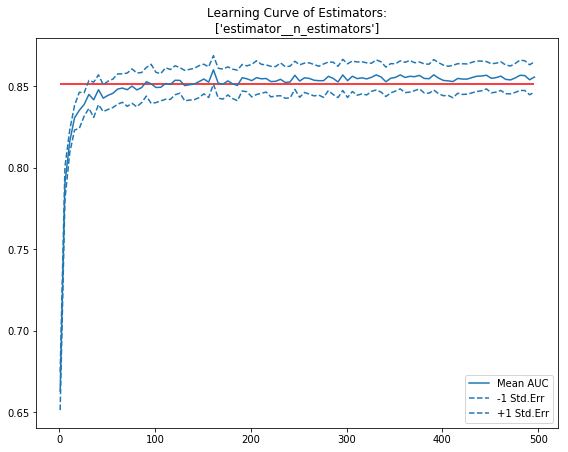

In [152]:
rdf.addIteration("Estimators", RandomForestClassifier(),
                {'estimator__n_estimators': list(range(1,500,5))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 2

Best Score: 0.833517

Best Params:  {'estimator__max_features': 43}


{'max_features': 0.40425531914893614}

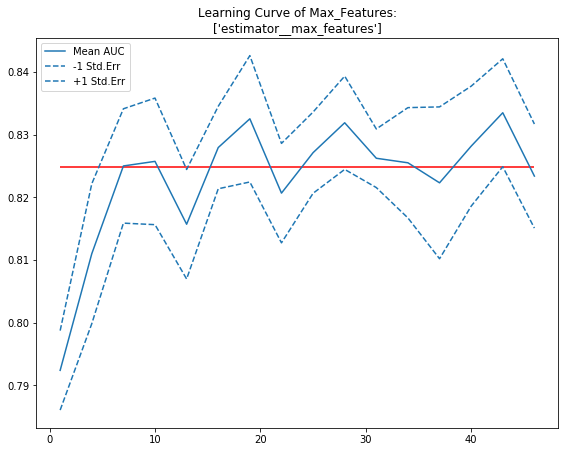

In [153]:
rdf.addIteration("Max_Features", RandomForestClassifier(**rdf.parameters),
                {'estimator__max_features': list(range(1,X_trained.shape[1],3))}, 
                reg = True, plot = True)

if 'max_features' in rdf.parameters:
    rdf.parameters['max_features'] = rdf.parameters['max_features']/X_trained.shape[1]
rdf.parameters

## Iteration 3

Best Score: 0.848837

Best Params:  {'estimator__min_samples_leaf': 14}


{'max_features': 0.40425531914893614, 'min_samples_leaf': 12}

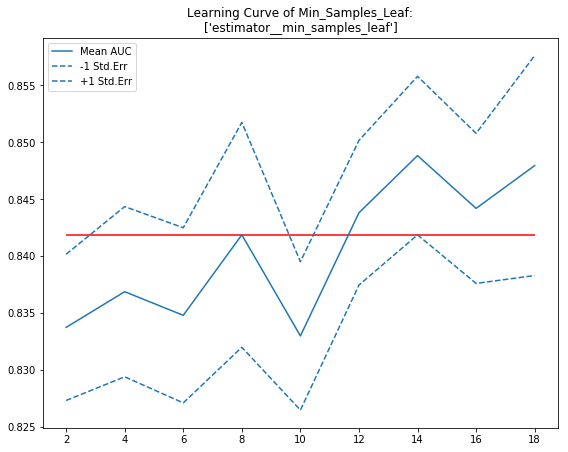

In [154]:
rdf.addIteration("Min_Samples_Leaf", RandomForestClassifier(**rdf.parameters),
                {'estimator__min_samples_leaf': list(range(2,20,2))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 4

Best Score: 0.850601

Best Params:  {'estimator__min_samples_split': 30}


{'max_features': 0.40425531914893614,
 'min_samples_leaf': 12,
 'min_samples_split': 8}

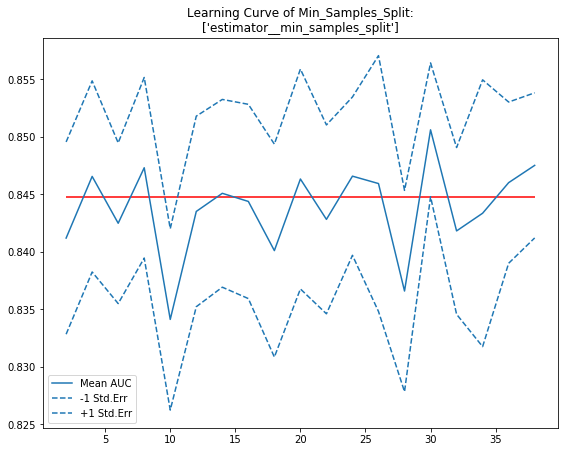

In [155]:
rdf.addIteration("Min_Samples_Split", RandomForestClassifier(**rdf.parameters),
                {'estimator__min_samples_split':list(range(2,40,2))}, 
                 reg = True, plot = True)

rdf.parameters

## Compare RDF

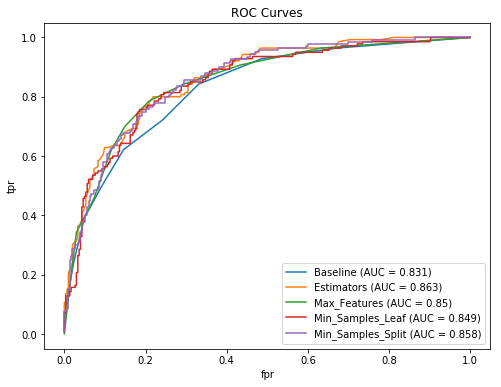

In [156]:
rdf.withinCompare()

# SGD

## Model Initialization

In [157]:
sgd = Model("SGD", SGDClassifier(loss = "log", fit_intercept = True, tol = None), 
            X_trained, y_train, X_tested, y_test)

sgd.parameters['loss']= "log"
sgd.parameters['fit_intercept'] = False
sgd.parameters['max_iter'] = 5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


## Iteration 1

Best Score: 0.688359

Best Params:  {'estimator__alpha': 10}


{'fit_intercept': False, 'loss': 'log', 'max_iter': 5}

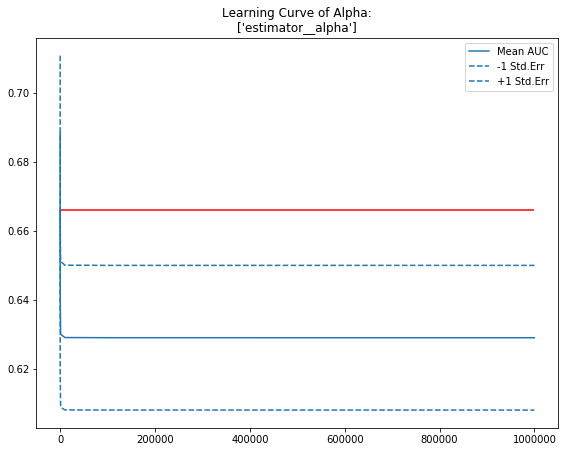

In [158]:
sgd.addIteration("Alpha", SGDClassifier(**sgd.parameters),
                 {'estimator__alpha': [10**x for x in range(1,7)]},
                 reg = True, plot = True)

sgd.parameters

## Iteration 2

Best Score: 0.691479

Best Params:  {'estimator__average': True}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


{'average': 1, 'fit_intercept': False, 'loss': 'log', 'max_iter': 5}

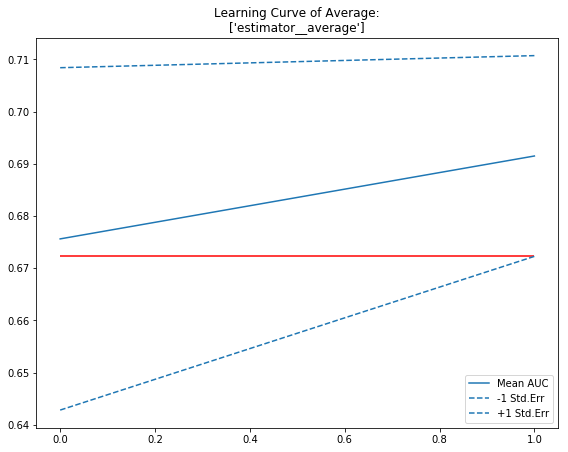

In [159]:
sgd.addIteration("Average", SGDClassifier(**sgd.parameters),
                 {'estimator__average': [False, True]})

sgd.parameters

## Iteration 3

Best Score: 0.705899

Best Params:  {'estimator__max_iter': 910}


{'average': 1, 'fit_intercept': False, 'loss': 'log', 'max_iter': 510}

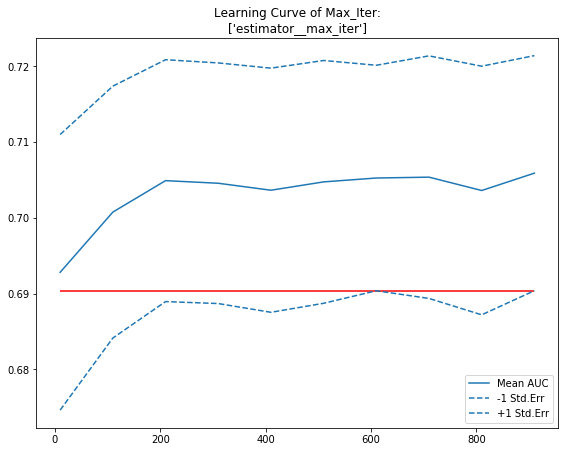

In [160]:
sgd.addIteration("Max_Iter", SGDClassifier(**sgd.parameters),
                 {'estimator__max_iter': list(range(10,1000,100))},
                 reg = True, plot = True)

sgd.parameters

## SGD Compare

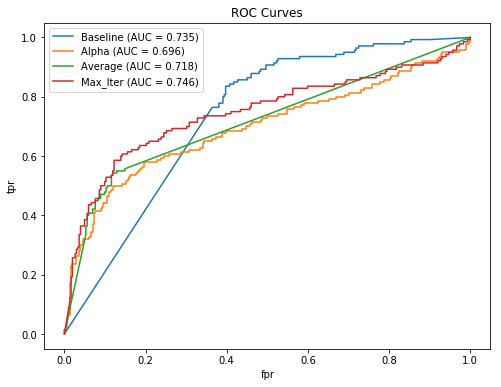

In [161]:
sgd.withinCompare()

# Dimension Reduction

## EDA

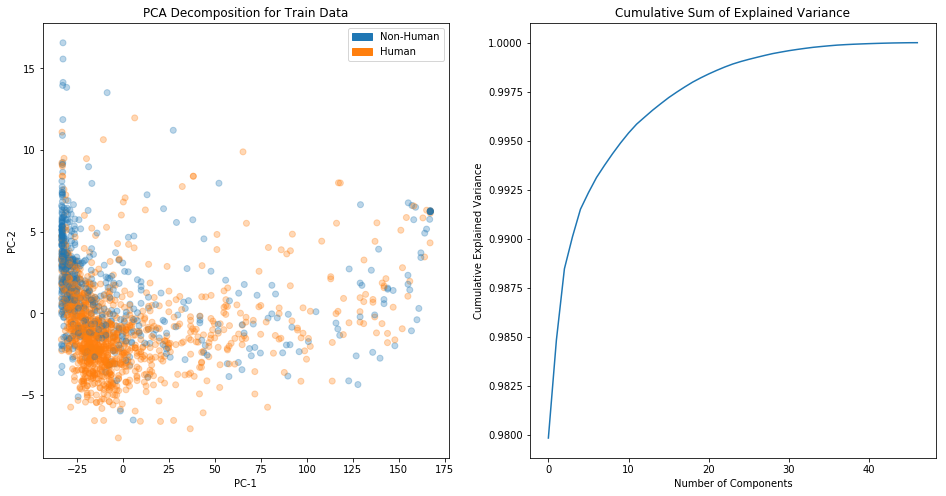

In [162]:
pca_eda = PCA()
pca_eda.fit(X_trained)

pc = pd.DataFrame(pca_eda.fit_transform(X_trained), index = X_trained.index)
pc = pc.join(y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
ax1.scatter(pc.iloc[:,0],
            pc.iloc[:,1],
            color=['C0' if x==1 else 'C1' for x in pc['label']],
            alpha=0.3)

ax1.set_title("PCA Decomposition for Train Data")
ax1.set_xlabel("PC-1")
ax1.set_ylabel("PC-2")
orange_patch = mpatches.Patch(color='C0', label='Non-Human')
blue_patch = mpatches.Patch(color='C1', label='Human')
ax1.legend(handles=[orange_patch, blue_patch])

ax2.plot(pca_eda.explained_variance_ratio_.cumsum())
ax2.set_title("Cumulative Sum of Explained Variance")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Cumulative Explained Variance")

## Model Initialization

In [163]:
pca = PCA(whiten = True)

pipe = Pipeline(steps=[('pca', pca), ('boosted', GradientBoostingClassifier())])
#pca.fit(X_trained)

#X_train_pca = pd.DataFrame(pca1.transform(X_trained))
#X_test_pca = pd.DataFrame(pca1.transform(X_tested))

gbc_pca = Model("Dimension Reduction", pipe, X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.820421

Best Params:  {'estimator__pca__n_components': 16}


{'pca__n_components': 16}

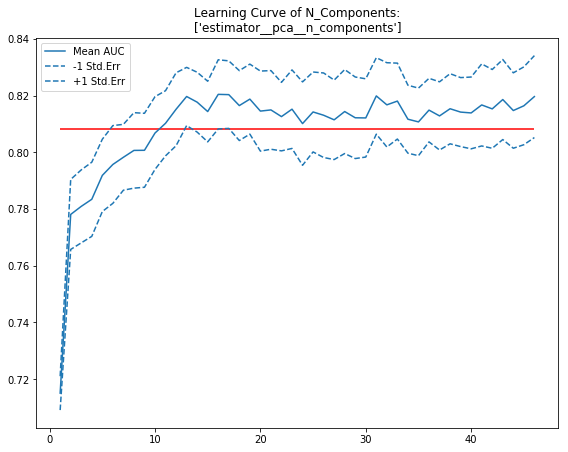

In [164]:
gbc_pca.addIteration("N_Components", pipe, 
                     dict(estimator__pca__n_components = list(range(1,X_trained.shape[1]))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 2

Best Score: 0.817861

Best Params:  {'estimator__boosted__n_estimators': 70}


{'boosted__n_estimators': 70, 'pca__n_components': 16}

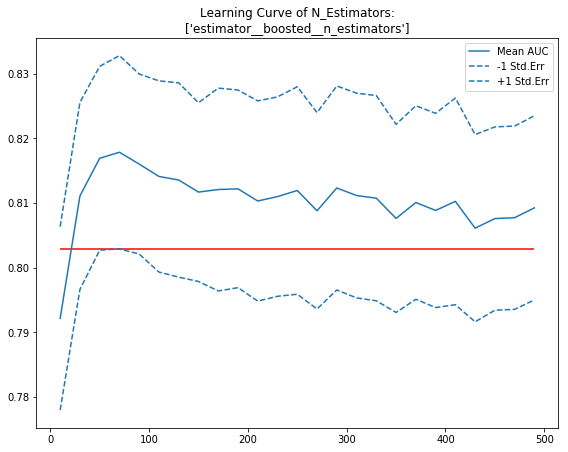

In [165]:
#gb2 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])
#pca2 = PCA(whiten = True)
#pca2.fit(X_trained)

#gbc_pca.X_train = pd.DataFrame(pca2.transform(X_trained))
#gbc_pca.X_test = pd.DataFrame(pca2.transform(X_tested))

pipe = Pipeline(steps=[('pca', pca), 
                       ('boosted', GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1]))])

gbc_pca.addIteration("N_Estimators", pipe, 
                     dict(estimator__boosted__n_estimators = list(range(10,500,20))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 3

Best Score: 0.819098

Best Params:  {'estimator__boosted__max_depth': 5}


{'boosted__max_depth': 5,
 'boosted__n_estimators': 70,
 'max_depth': 2,
 'pca__n_components': 16}

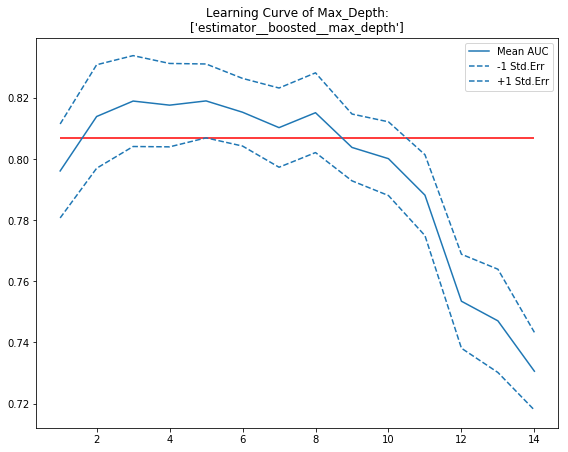

In [166]:
pipe = Pipeline(steps=[('pca', pca), 
                       ('boosted', GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1]))])

gbc_pca.addIteration("Max_Depth", pipe, 
                     dict(estimator__boosted__max_depth = list(range(1,15))), 
                     reg = False, plot = True)

gbc_pca.parameters['max_depth'] = 2
gbc_pca.parameters

## Iteration 4

Best Score: 0.825385

Best Params:  {'estimator__boosted__min_samples_leaf': 5}


{'boosted__max_depth': 5,
 'boosted__min_samples_leaf': 5,
 'boosted__n_estimators': 70,
 'max_depth': 2,
 'pca__n_components': 16}

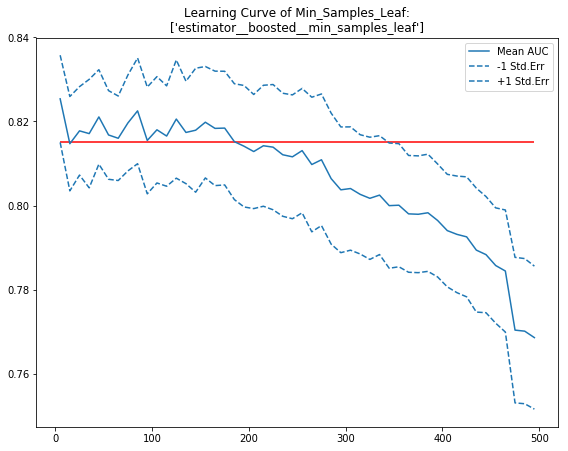

In [167]:
pipe = Pipeline(steps=[('pca', pca), 
                       ('boosted', GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1]))])

gbc_pca.addIteration("Min_Samples_Leaf", pipe, 
                     dict(estimator__boosted__min_samples_leaf = list(range(5,500,10))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 5

Best Score: 0.822374

Best Params:  {'estimator__boosted__subsample': 0.80000000000000004}


{'boosted__max_depth': 5,
 'boosted__min_samples_leaf': 5,
 'boosted__n_estimators': 70,
 'boosted__subsample': 0.80000000000000004,
 'max_depth': 2,
 'pca__n_components': 16}

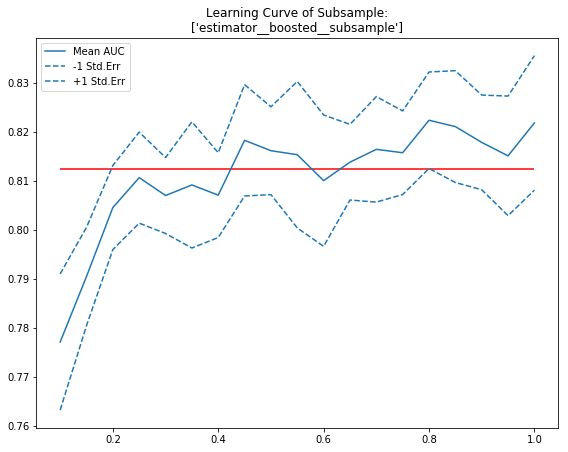

In [168]:
pipe = Pipeline(steps=[('pca', pca), 
                       ('boosted', GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1]))])

gbc_pca.addIteration("Subsample", pipe, 
                     dict(estimator__boosted__subsample = np.array(list(range(10,105,5)))/100), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 6

Best Score: 0.818408

Best Params:  {'estimator__boosted__learning_rate': 0.1}


{'boosted__learning_rate': 0.10000000000000001,
 'boosted__max_depth': 5,
 'boosted__min_samples_leaf': 5,
 'boosted__n_estimators': 70,
 'boosted__subsample': 0.80000000000000004,
 'max_depth': 2,
 'pca__n_components': 16}

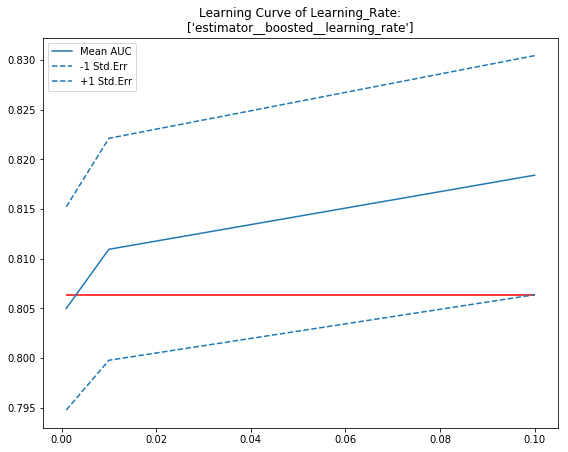

In [169]:
pipe = Pipeline(steps=[('pca', pca), 
                       ('boosted', GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1]))])

gbc_pca.addIteration("Learning_Rate", pipe, 
                     dict(estimator__boosted__learning_rate = [10**x for x in range(-3,0)]), 
                     reg = False, plot = True)

gbc_pca.parameters

## GBC_PCA Compare

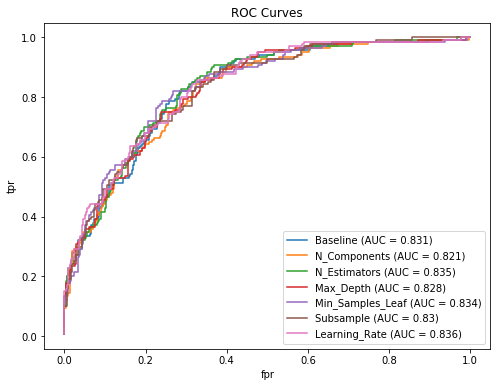

In [170]:
gbc_pca.withinCompare()

# Model Comparison


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Pro

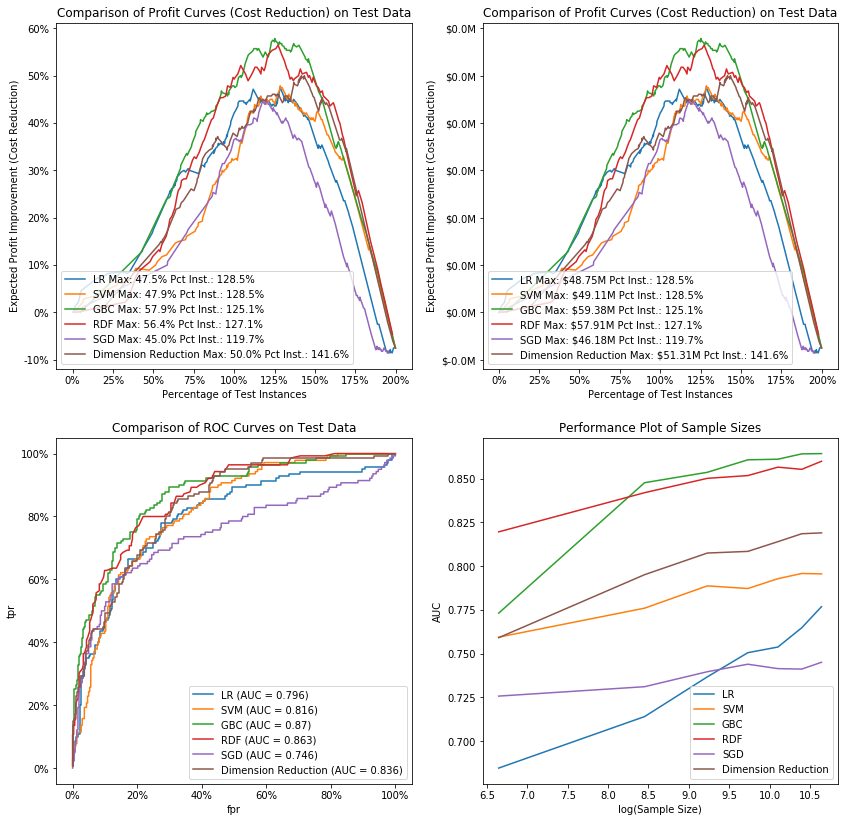

In [173]:
plotPerformance([lrc, svm, gbc, rdf, sgd, gbc_pca], list(range(100, X_trained.shape[0], 250)), 20)